In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
Find how long a catchup period typically was

"""
import numpy as np

from ema import read

meal_df = read.raw_meal_info()

# Add a timestamp
meal_df["Datetime"] = read._datetime(meal_df)
meal_df.set_index("Datetime", inplace=True)

catchup = False
start_time = None
catchup_lengths = []
start_times = []

for time, entry in meal_df["meal_type"].items():
    if entry == "Catch-up start":
        catchup = True
        start_time = time

    elif entry == "Catch-up end":
        catchup_lengths.append((time - start_time).seconds)
        start_times.append(start_time.time())
        catchup = False

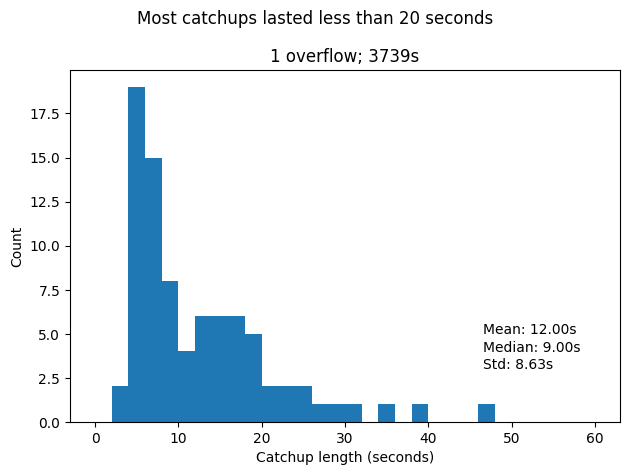

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

bins = np.linspace(0, 60, 31)

fig, axis = plt.subplots()
count, bins, artists = axis.hist(catchup_lengths, bins=bins)

axis.set_xlabel("Catchup length (seconds)")
axis.set_ylabel("Count")
fig.suptitle("Most catchups lasted less than 20 seconds")

overflow_lens = [str(l) for l in catchup_lengths if l > bins[-1]]

axis.set_title(f"{len(overflow_lens)} overflow; {', '.join(overflow_lens)}s")

# Add some stats
x_pos, y_pos = 0.75, 0.25
times_in_plot = [l for l in catchup_lengths if l < bins[-1]]
axis.text(
    x_pos, y_pos, f"Mean: {np.mean(times_in_plot):.2f}s", transform=axis.transAxes
)
axis.text(
    x_pos,
    y_pos - 0.05,
    f"Median: {np.median(times_in_plot):.2f}s",
    transform=axis.transAxes,
)
axis.text(
    x_pos, y_pos - 0.1, f"Std: {np.std(times_in_plot):.2f}s", transform=axis.transAxes
)
fig.tight_layout()

fig.savefig("img/catchup_lengths.png", dpi=300)

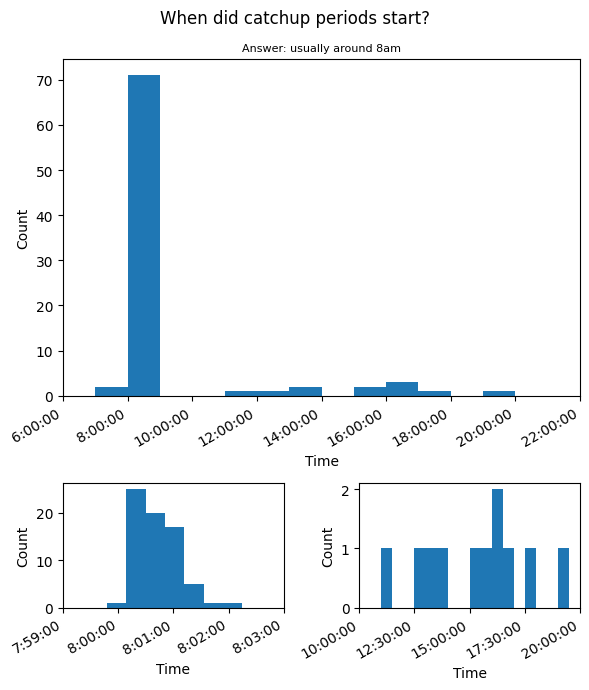

In [72]:
"""
When did they occur?

"""
import datetime

seconds_past_midnight = [
    time.hour * 3600 + time.minute * 60 + time.second for time in start_times
]

fig, axes = plt.subplot_mosaic("AAAA\nAAAA\nBBCC", figsize=(6, 7))

# The whole period
bins = np.linspace(0, 86400, 25)
axes["A"].hist(seconds_past_midnight, bins=bins)

# Around 8am
bins = 3600 * 8 + 60 * np.linspace(-3, 4, 21)
ticks = 3600 * 8 + 60 * np.linspace(-1, 3, 5)
axes["B"].set_xticks(
    ticks,
    [str(datetime.timedelta(seconds=time)) for time in ticks],
    rotation=30,
    ha="right",
)
axes["B"].hist(seconds_past_midnight, bins=bins)
axes["B"].set_xlim(ticks[0], ticks[-1])

# Later in the afternoon/evening
bins = 3600 * 10 + 3600 * np.linspace(0, 10, 21)
ticks = 3600 * 10 + 3600 * np.linspace(0, 10, 5)
axes["C"].set_xticks(
    ticks,
    [str(datetime.timedelta(seconds=time)) for time in ticks],
    rotation=30,
    ha="right",
)
axes["C"].hist(seconds_past_midnight, bins=bins)
axes["C"].set_xlim(ticks[0], ticks[-1])

# Convert x ticks from seconds past midnight to a timestamp
times = [3600 * x for x in range(6, 23, 2)]
axes["A"].set_xticks(
    times,
    [str(datetime.timedelta(seconds=time)) for time in times],
    rotation=30,
    ha="right",
)
axes["A"].set_xlim(times[0], times[-1])


fig.suptitle("When did catchup periods start?")
axes["A"].set_title("Answer: usually around 8am", fontsize=8)

for axis in axes.values():
    axis.set_xlabel("Time")
    axis.set_ylabel("Count")
# fig.autofmt_xdate()
fig.tight_layout()

fig.savefig("img/catchup_times.png", dpi=300)